---
title: Re-annotation and classification
---

In [1]:
import scvi
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt


from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde


import warnings
from lightning_fabric.plugins.environments.slurm import PossibleUserWarning
warnings.simplefilter(action='ignore', category=PossibleUserWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

scvi.settings.seed = 42

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 42


In [2]:
%run ../scripts/helpers.py

In [3]:
sc.set_figure_params(figsize=(10, 6))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [4]:
lvae = scvi.model.SCANVI.load("../results/02_human_integration/scanvi/")
human_adata = lvae.adata.copy()

INFO     File ../results/02_human_integration/scanvi/model.pt already downloaded                                   


In [7]:
human_adata.obs['C_scANVI'] = lvae.predict(human_adata)

human_adata.obs['updated_ct'] = human_adata.obs['ct_fine'].tolist()
human_adata.obs.loc[human_adata.obs['updated_ct'] == 'Unknown','updated_ct'] = human_adata.obs.loc[human_adata.obs['updated_ct'] == 'Unknown','C_scANVI']

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


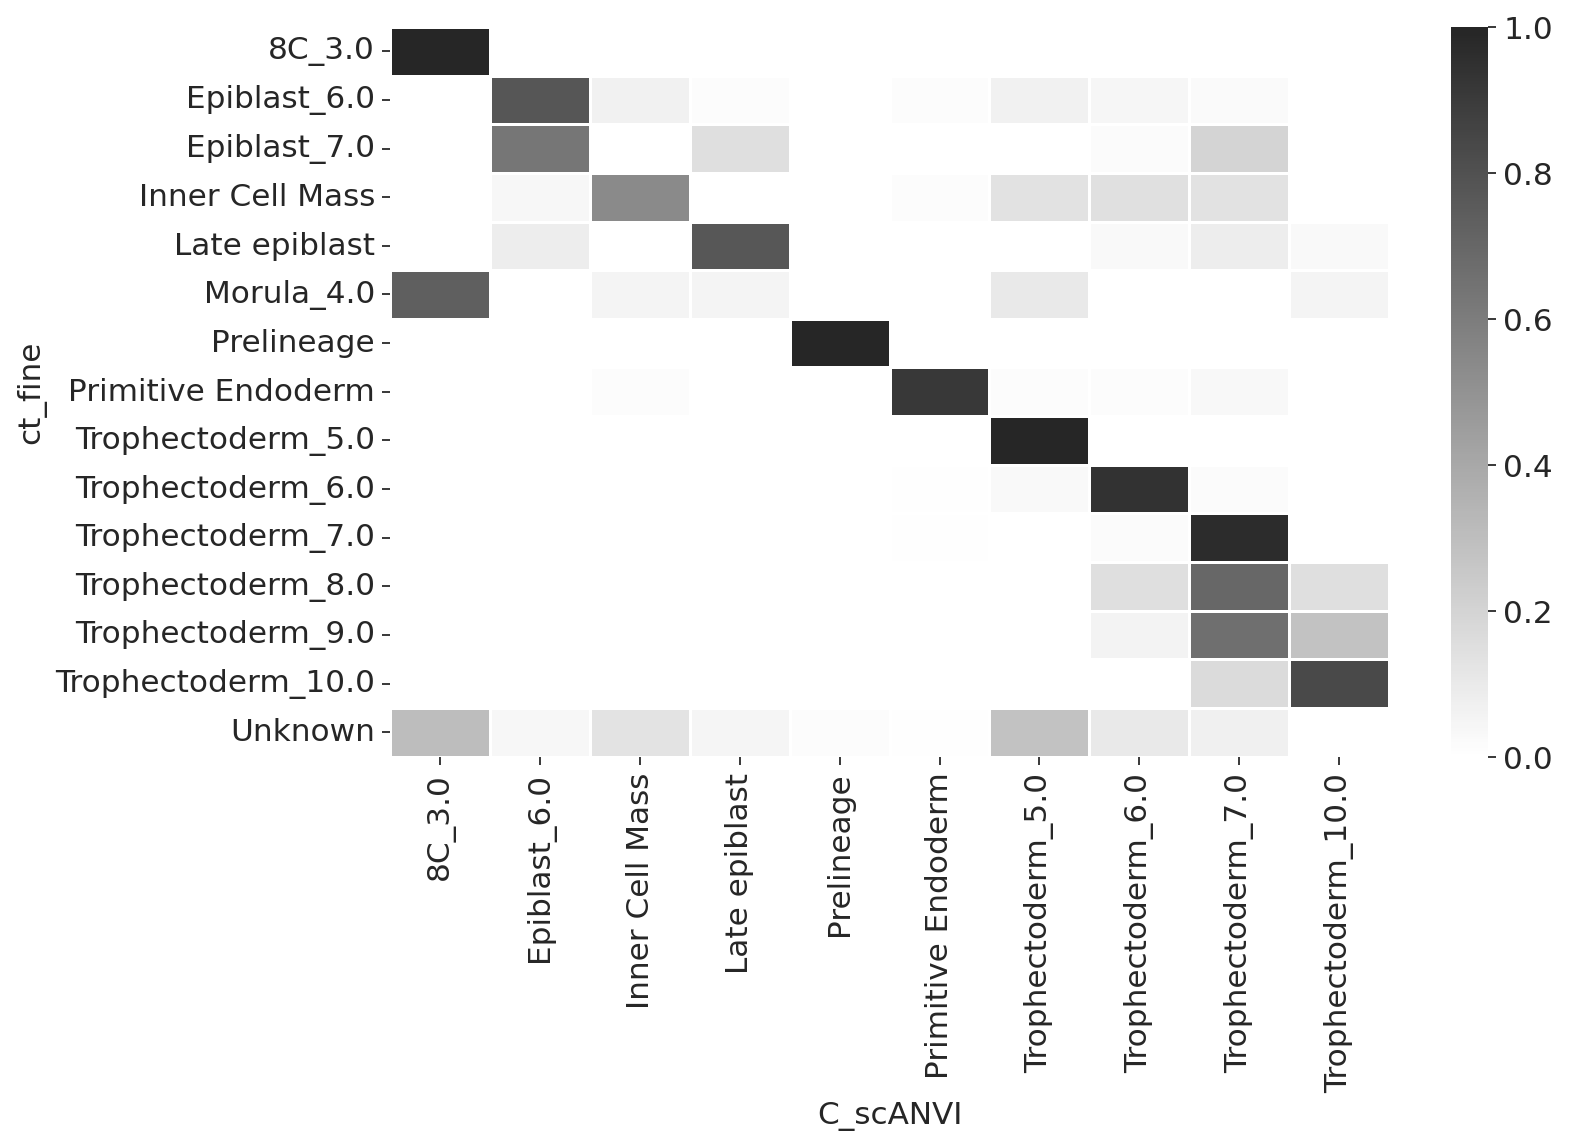

In [8]:
cmtx = sc.metrics.confusion_matrix("ct_fine", "C_scANVI", human_adata.obs)
with sns.axes_style("ticks"):
    sns.heatmap(cmtx, cmap=sns.dark_palette("white", reverse=True, as_cmap=True),linewidth=.5)

In [16]:
lvae_nsamples = scvi.model.SCANVI.from_scvi_model(
    scvi.model.SCVI.load("../results/02_human_integration/scvi/"),
    adata=human_adata,
    labels_key="ct_fine",
    unlabeled_category="Unknown",
)
lvae_nsamples.train(
    n_samples_per_label = 15,
)

INFO     File ../results/02_human_integration/scvi/model.pt already downloaded                                     
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 10/10: 100%|███████████████| 10/10 [00:03<00:00,  3.14it/s, v_num=1, train_loss_step=6.53e+3, train_loss_epoch=6.54e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|███████████████| 10/10 [00:03<00:00,  3.12it/s, v_num=1, train_loss_step=6.53e+3, train_loss_epoch=6.54e+3]


In [18]:
human_adata.obs["C_scANVI_nsamples"] = lvae_nsamples.predict(human_adata)

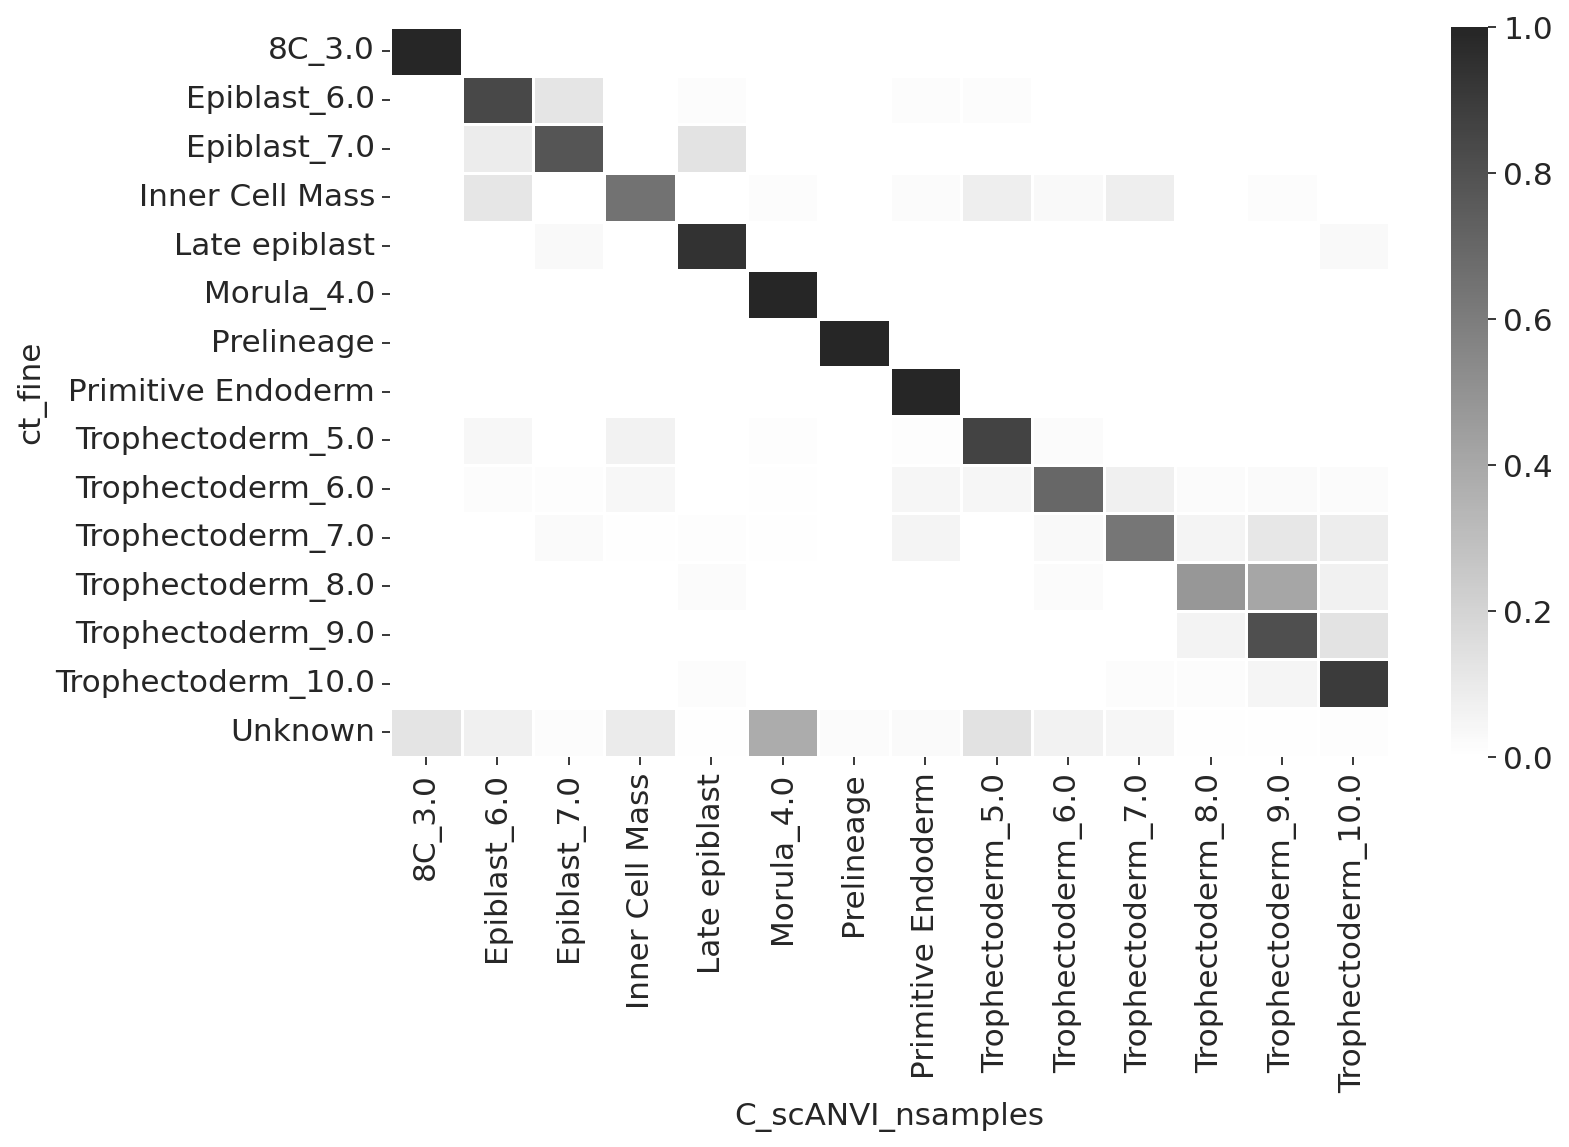

In [19]:
cmtx = sc.metrics.confusion_matrix("ct_fine", "C_scANVI_nsamples", human_adata.obs)

with sns.axes_style("ticks"):
    sns.heatmap(cmtx, cmap=sns.dark_palette("white", reverse=True, as_cmap=True),linewidth=.5)

In [21]:
lvae_nsamples

ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: False

In [22]:
lvae_nsamples.save('../results/02_human_integration/05_scanvi_ns15/', save_anndata=True)